# Decision Tree Classifier

Load necessary packages

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score
from sklearn.tree import plot_tree
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, make_scorer, fbeta_score, f1_score, auc
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import classification_report
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import RocCurveDisplay

### Data preparation

Load training dataset

In [3]:
train_df = pd.read_csv("data_train.csv")

Drop unnecessary "id" column

In [4]:
train_df.drop("id", axis = "columns", inplace = True)

Load testing dataset

In [5]:
test_df = pd.read_csv("data_test.csv")

Drop unnecessary "id" column

In [6]:
test_df.drop("id", axis="columns", inplace= True)

Split the data into features and targets

In [7]:
X_train = train_df.drop("stroke", axis = "columns")
y_train = train_df.stroke
X_test = test_df.drop("stroke", axis = "columns")
y_test = test_df.stroke

### One hot encoding for categorical variables

This type of encoding is the most appropriate as it creates boolean variables out of categorial variables with more than two outcomes. It is more suitable than label encoding because it avoids unwanted ordinal relationships between the outcomes of categorial variables.

Extract the names of categorial variables

In [8]:
categories = train_df.select_dtypes(include=['object']).columns.tolist()

Encode the variables avoiding the sparse matrix output and dropping first varible output for each variable to avoid the dummy trap.

In [9]:
encoder = OneHotEncoder(sparse_output = False, drop = "first")
encoder.fit(X_train[categories])
encoder.fit(X_test[categories])

OneHotEncoder(drop='first', sparse_output=False)

Make some additional steps to replace the original data with encoded data.

In [10]:
X_train_encoded = encoder.transform(X_train[categories])
X_test_encoded = encoder.transform(X_test[categories])
columns = encoder.get_feature_names_out(categories)
X_train_encoded_df = pd.DataFrame(X_train_encoded, columns=columns, index=X_train.index)
X_test_encoded_df = pd.DataFrame(X_test_encoded, columns=columns, index=X_test.index)


Prepare final feature datasets

In [11]:
X_train_preprocessed = pd.concat([X_train.drop(categories, axis=1), X_train_encoded_df], axis=1)
X_test_preprocessed = pd.concat([X_test.drop(categories, axis=1), X_test_encoded_df], axis=1)

Adjust column name to remove whitespace.

In [12]:
colnames = X_test_preprocessed.columns.to_list()

In [13]:
colnames[-5] = "smoking_status_never_smoked"

### Finding the best hyperparameters

Use grid search cross validation with 5 fold strategy and f1 scoring.

In [14]:
param_grid = {
    'criterion': ['entropy'],
    'max_depth': [3],
    'min_samples_split': [20, 30, 50, 100],
    'min_samples_leaf': [30, 50, 100],
    'class_weight': [{0:1, 1:5}, {0:1, 1:10}, {0:1, 1:20}]
}

f1_positive_scorer = make_scorer(f1_score, pos_label=1)

cv_strategy = StratifiedKFold(n_splits=5)

dt_1 = DecisionTreeClassifier(random_state=42)

grid_search = GridSearchCV(
    estimator=dt_1, 
    param_grid=param_grid,
    cv=cv_strategy,
    scoring=f1_positive_scorer) 

grid_search.fit(X_train_preprocessed, y_train)

best_parameters = grid_search.best_params_
best_score = grid_search.best_score_

print('Best parameters:', best_parameters)
print('Best score:', best_score)

Best parameters: {'class_weight': {0: 1, 1: 10}, 'criterion': 'entropy', 'max_depth': 3, 'min_samples_leaf': 100, 'min_samples_split': 20}
Best score: 0.24876799298028854


### Training a classifier with the best parameters

In [15]:
best_classifier = DecisionTreeClassifier(**best_parameters, random_state=42)
best_classifier.fit(X_train_preprocessed, y_train)

DecisionTreeClassifier(class_weight={0: 1, 1: 10}, criterion='entropy',
                       max_depth=3, min_samples_leaf=100, min_samples_split=20,
                       random_state=42)

Predicting values for the testing data

In [16]:
y_pred = best_classifier.predict(X_test_preprocessed)

### Check for overfitting.

Compare the f1 scores of training and testing datasets to detect possible overfitting.

In [17]:
y_train_pred = best_classifier.predict(X_train_preprocessed)
train_f1_score = f1_score(y_train_pred, y_train, pos_label=1)
test_f1_score = f1_score(y_pred, y_test, pos_label=1)

In [18]:
print(f"Training set f1_score: {train_f1_score}")
print(f"Test set f1_score: {test_f1_score}")

if train_f1_score > test_f1_score + 0.05:  # threshold of 5% difference
    print("The model may be overfitting to the training data.")
else:
    print("The model does not appear to be overfitting.")

Training set f1_score: 0.2537037037037037
Test set f1_score: 0.279245283018868
The model does not appear to be overfitting.


### Evaluation of the decision tree classifier

We evaluate the model using multiple suitable metrics.

In [19]:
accuracy = accuracy_score(y_test, y_pred)
conf_matrix = confusion_matrix(y_test, y_pred)
precision = precision_score(y_test, y_pred, average='binary')
recall = recall_score(y_test, y_pred, average='binary')
f1 = f1_score(y_test, y_pred, average='binary')

In [21]:
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1 Score: {f1:.4f}")

Accuracy: 0.8131
Precision: 0.1721
Recall: 0.7400
F1 Score: 0.2792


We find with great appreciation the recall score to be higher than precision, which demonstrates the model's ability to avoid false negatives better than false positives. 

### Confusion matrix visualization

<Figure size 800x600 with 0 Axes>

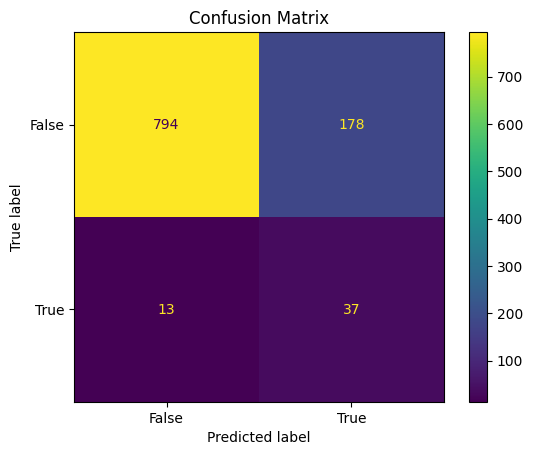

In [22]:
plt.figure(figsize=(8, 6))
ConfusionMatrixDisplay.from_predictions(y_test, y_pred=y_pred)
plt.title('Confusion Matrix')
plt.show()

### ROC curve visualization

The shape of the model's ROC curve indicates the relationship between True Positive Rate and False Positive Rate. Area Under Curve equal to 0.82 indicates better than random classification ability.

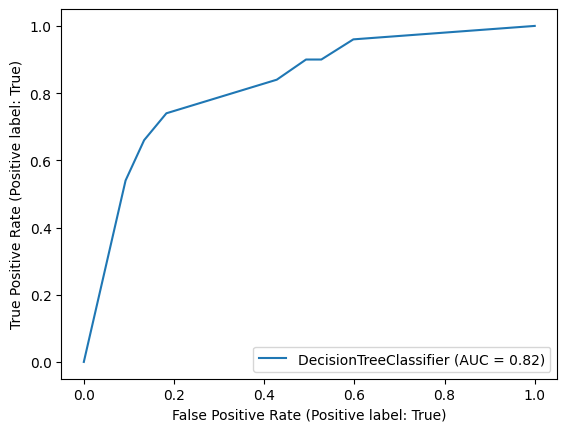

In [23]:
clf_disp = RocCurveDisplay.from_estimator(best_classifier, X_test_preprocessed, y_test)
plt.show()

### Cost matrix

As false negative statement about having a stroke is more severe than a false positive statement, we chose C(FN) = 5 and c(FP) = 1, costs of true predctions both left at 0.

In [24]:
cost_matrix = np.array([[0, 1],
                        [5, 0]])

total_cost = np.sum(cost_matrix * conf_matrix)
print(f"The total cost of the classifier is {total_cost}.")

The total cost of the classifier is 243.


### Visualization of the decision tree

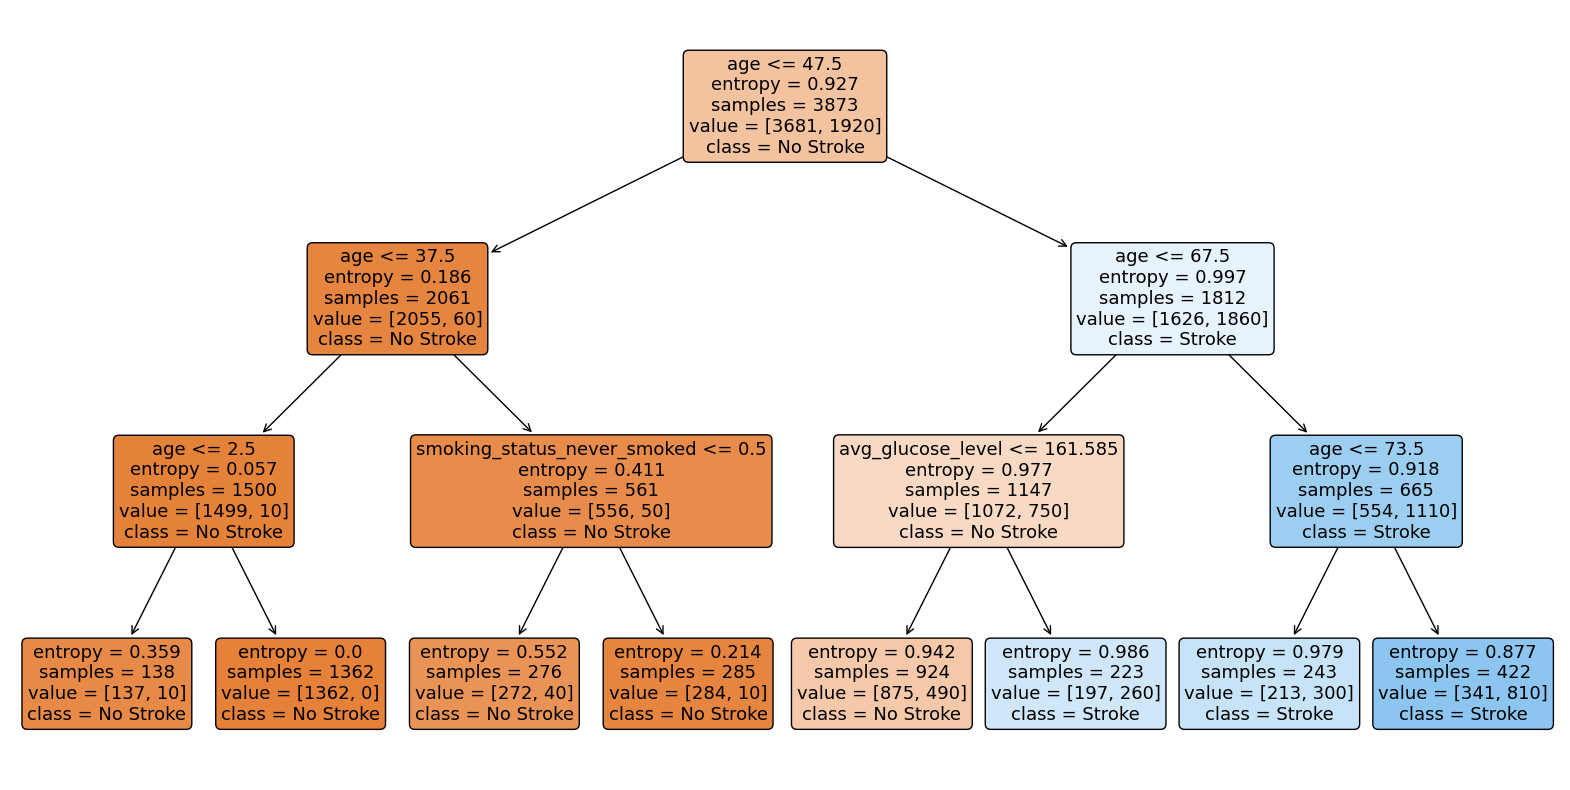

In [25]:
plt.figure(figsize=(20,10))
plot_tree(best_classifier, 
          filled=True, 
          rounded=True, 
          fontsize= 13,
          class_names=['No Stroke', 'Stroke'], 
          feature_names=colnames)
plt.show()

### Classification of a random instance

In [26]:
chosen_inst = X_test_preprocessed.iloc[[69,]]
chosen_inst

,age,hypertension,heart_disease,ever_married,avg_glucose_level,bmi,gender_Male,work_type_Never_worked,work_type_Private,work_type_Self-employed,work_type_children,Residence_type_Urban,smoking_status_never smoked,smoking_status_smokes,glucose_level_diagnosis_hypoglycemia,glucose_level_diagnosis_non-diabetic,glucose_level_diagnosis_pre-diabetic
69,18.0,False,False,False,108.87,21.5,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0


By following the decision tree, we arrive at the instance being classified as class = No Stroke.